# Puma 560 - Square path

## Moran Garcia Daniel - Brunett Chavez Lex - Delgado Zambrano Jose - Trivino Gonzalez Hector

### Import libraries

In [24]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import roboticstoolbox as rtb
from math import pi
from spatialmath import *
from spatialmath.base import *

### Analysis of trapezoidal and polynomial interpolation

In [25]:
steps = 100
max_val = 10
min_val = 0

step = (max_val - min_val)/steps

tp = rtb.lspb(min_val, max_val, steps)
pol = rtb.tpoly(min_val, max_val, steps)
step_series = np.arange(min_val, steps, 1)

def graph_curve(title, step_series, pol_curve, tp_curve):
    plt.title(title)
    plt.plot(step_series, pol_curve, label="polinomial")
    plt.plot(step_series, tp_curve, label="traprezoidal")
    plt.legend(framealpha=1, frameon=True)

<IPython.core.display.Javascript object>


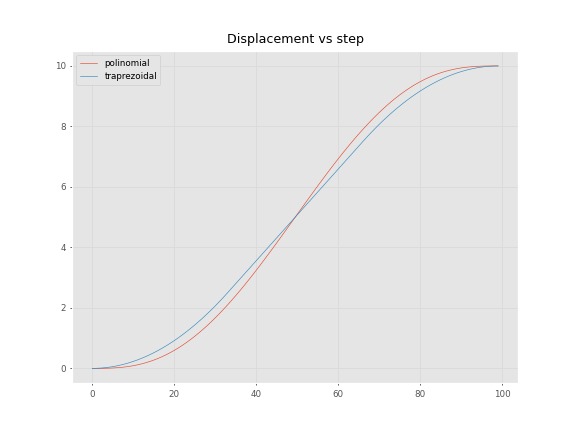

In [26]:
# Displacement vs time
graph_curve("Displacement vs step", step_series, pol.q, tp.q)

<IPython.core.display.Javascript object>


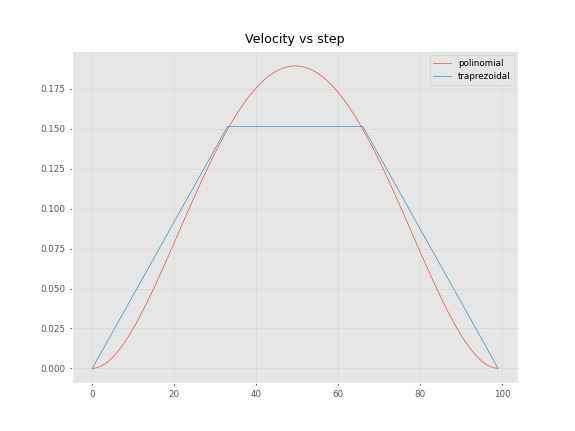

In [27]:
# Velocity vs time
graph_curve("Velocity vs step", step_series, pol.qd, tp.qd)

<IPython.core.display.Javascript object>


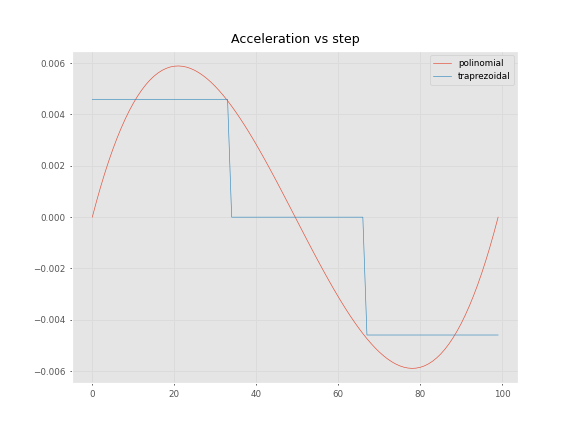

In [28]:
# Acceleration vs time
graph_curve("Acceleration vs step", step_series, pol.qdd, tp.qdd)

### Trapezoidal interpolation

In [76]:
# The following coordinates are the vertix of the square
A_coord = {"x": 0.3, "y": 0.15, "z": 0}
B_coord = {"x": 0.15, "y": 0.15, "z": 0}
C_coord = {"x": 0.15, "y": 0.3, "z": 0}
D_coord = {"x": 0.3, "y": 0.3, "z": 0}

STEPS = 20

In [77]:
"""
def get_trapezoidal_path(c_A, c_B):
    path = []
    if(c_A.size == c_B.size):
        for i in range(c_A.size):
            tp = rtb.lspb(c_A[i], c_B[i], STEPS)
            path.append(tp)
    return path

def get_joint_displacement(joint_path):
    mat = []
    for i in range(len(joint_path)):
        mat.append(joint_path[i].q)
    mat = np.array(mat)
    return mat.transpose()
"""


def get_SE3_matrix(coordinates):
    return SE3(coordinates["x"], coordinates["y"], coordinates["z"])

def get_trap_path(c_A, c_B):
    path = {}
    if(len(c_A) == len(c_B)):
        for key in c_A:
            if(c_A[key] != c_B[key]):
                tp = rtb.lspb(c_A[key], c_B[key], STEPS)
                path[key] = tp
            else:
                path[key] = c_A[key]
    return path

def get_trj_coord(path):
    tj = []
    for key in path:
        if isinstance(path[key], int) or isinstance(path[key], float):
            tj.append(np.full((1, STEPS), path[key])[0])
        else:
            tj.append(path[key].q)
    tj = np.array(tj)
    return tj.transpose()

def ikin_from_trj_coord(trj):
    inverse_kin_trj = []
    for ind_trj in trj:
        coord = {"x": ind_trj[0], "y": ind_trj[1], "z": ind_trj[2]}
        ikin = puma.ikine_min(get_SE3_matrix(coord))
        inverse_kin_trj.append(ikin.q)
    return np.array(inverse_kin_trj)

def get_ikin(coord_0, coord_1):
    path = get_trap_path(coord_0, coord_1)
    return ikin_from_trj_coord(get_trj_coord(path))

<IPython.core.display.Javascript object>


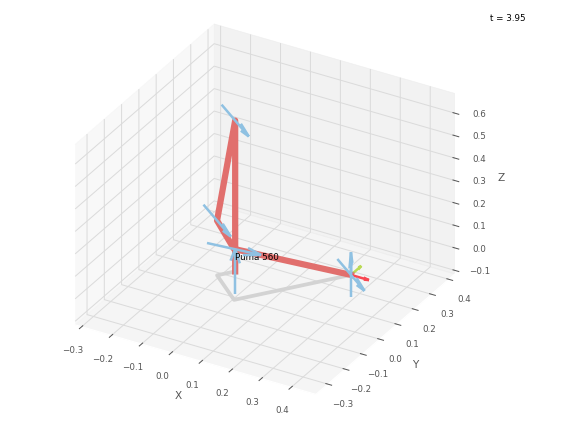

PyPlot3D backend, t = 3.999999999999994, scene:
  Puma 560

In [78]:
ikin_trjAB = get_ikin(A_coord, B_coord)
ikin_trjBC = get_ikin(B_coord, C_coord)
ikin_trjCD = get_ikin(C_coord, D_coord)
ikin_trjDA = get_ikin(D_coord, A_coord)

ikin_trjAC = np.concatenate((ikin_trjAB, ikin_trjBC), axis=0)
ikin_trjCA = np.concatenate((ikin_trjCD, ikin_trjDA), axis=0)
ikin_trj_gen = np.concatenate((ikin_trjAC, ikin_trjCA), axis=0)

puma.plot(ikin_trj_gen)

<IPython.core.display.Javascript object>


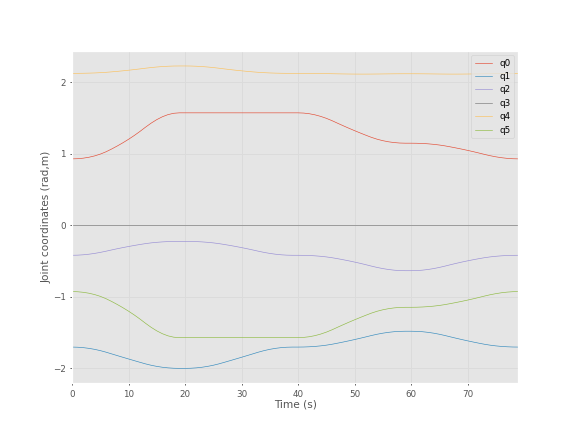

[<AxesSubplot:xlabel='Time (s)', ylabel='Joint coordinates (rad,m)'>]

In [79]:
rtb.tools.trajectory.qplot(ikin_trj_gen, block=True)